## Predicting World Cup 2018 Winner
In this Jupyter Notebook, I'm going to present a Machine Learning model to try to predict the outcomes of all games in World Cup 2018, which also means predicting the winner of the championship. 

We're going first to do some exploratory analysis on two datasets obtained from Kaggle. Then, we're going to do some feature engineering in order to select which features are the most relevant to the case in point, do some data manipulation, choose an ML model and finally deploy it on the dataset. 

### 1) Getting things ready
First step: import the necessary packages and read the files into pandas Dataframes.

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read .csv files
wc = pd.read_csv('World Cup 2018 Dataset.csv')
results = pd.read_csv('results.csv')

In [4]:
wc.head()

,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Porugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


In [5]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,London,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


### 2) Exploring and Manipulating the data
Now, we're going to play around with the second dataset ("results") and create two auxiliary columns that will tell us the absolute goal difference in each match and the outcome of which match (that is, which team won, or "Tie"). I believe these pieces of information should be useful when we arrive at the feature engineering discussion.

The Dataframe has an anormous amount of match records, but not all of them are actually useful for our analysis. We need to start thinking about which features exactly will be the most relevant for the ML model we are going to use. 

This is a very complex and time-consuming part of every Data Science project roadmap, so we are going to spend a good chunk of time here.

In [6]:
# Adding new column for winner of each match
winner = []
for i in range(len(results['home_team'])):
    if results['home_score'][i] > results['away_score'][i]:
        winner.append(results['home_team'][i])
    elif results['home_score'][i] < results['away_score'][i]:
        winner.append(results['away_team'][i])
    else:
        winner.append('Tie')
results['winning_team'] = winner

# Adding new column for goal difference in matches
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Tie,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


Let's work with a subset of the dataset: one that includes only games played by England. This will help us focus on what features would be interesting to observe for one country, and then we can later expand to all countries participating in the World Cup.

In [7]:
# Slice the dataset and create new 'england' Dataframe
df = results[(results['home_team'] == 'England') | (results['away_team'] == 'England')]
england = df.iloc[:]
england.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Tie,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


In [8]:
year = []

# Loop for creating a new column 'year'
for row in england['date']:
    year.append(int(row[:4]))
england['match_year'] = year

# Slicing the dataset to show matches only from 1930 onwards (the year of the first ever World Cup)
england[england.match_year > 1930]

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference,match_year
1343,1931-03-28,Scotland,England,2,0,British Championship,Glasgow,Scotland,Scotland,2,1931
1360,1931-05-14,France,England,5,2,Friendly,Colombes,France,France,3,1931
1362,1931-05-16,Belgium,England,1,4,Friendly,Brussels,Belgium,England,3,1931
1408,1931-10-17,Northern Ireland,England,2,6,British Championship,Belfast,Northern Ireland,England,4,1931
1414,1931-11-18,England,Wales,3,1,British Championship,Liverpool,England,England,2,1931
1420,1931-12-09,England,Spain,7,1,Friendly,London,England,England,6,1931
1436,1932-04-09,England,Scotland,3,0,British Championship,London,England,England,3,1932
1500,1932-10-17,England,Northern Ireland,1,0,British Championship,Blackpool,England,England,1,1932
1507,1932-11-16,Wales,England,0,0,British Championship,Wrexham,Wales,Tie,0,1932
1511,1932-12-07,England,Austria,4,3,Friendly,London,England,England,1,1932


Now let's try quickly visualizing the data to see which was the most common game outcome for England.

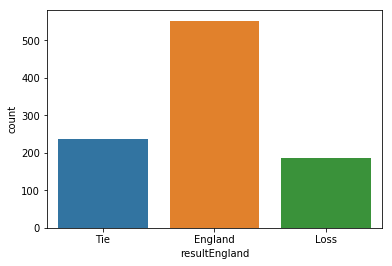

In [22]:
# Create auxiliary DataFrame for substituting other countries' names for 'Loss'
winrate = []
for row in england['winning_team']:
    if row != 'England' and row != 'Tie':
        winrate.append('Loss')
    else:
        winrate.append(row)
dfwinrate = pd.DataFrame(winrate, columns=['resultEngland'])

# Plot with Seaborn and show
sns.countplot(x='resultEngland', data=dfwinrate)
        